In [1]:
import kagglehub

# # Download latest version
path = kagglehub.dataset_download("shubhammeshram579/bank-customer-churn-prediction", 
                                  path="Churn_Modelling.csv")

print("Path to dataset files:", path)

d:\shap-project\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: C:\Users\himan\.cache\kagglehub\datasets\shubhammeshram579\bank-customer-churn-prediction\versions\1\Churn_Modelling.csv


In [2]:
import pandas as pd
import numpy as np
import shap
from sklearn import set_config
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# set config

set_config(transform_output="pandas")

In [4]:
# load the data

df = pd.read_csv(path)

df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42.0,2,0.00,1,1.0,1.0,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41.0,1,83807.86,1,0.0,1.0,112542.58,0
2,3,15619304,Onio,502,France,Female,42.0,8,159660.80,3,1.0,0.0,113931.57,1
3,4,15701354,Boni,699,France,Female,39.0,1,0.00,2,0.0,0.0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43.0,2,125510.82,1,NaN,1.0,79084.10,0


In [5]:
# shape of the data

df.shape

(10002, 14)

In [6]:
# check for missing values

df.isna().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          1
Gender             0
Age                1
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          1
IsActiveMember     1
EstimatedSalary    0
Exited             0
dtype: int64

In [7]:
df.isna().any(axis=1)

0        False
1        False
2        False
3        False
4         True
         ...  
9997     False
9998     False
9999     False
10000    False
10001    False
Length: 10002, dtype: bool

In [8]:
# find the rows having missing values

(
    df.loc[
        (df.isna().any(axis=1)), :
    ]
)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
4,5,15737888,Mitchell,850,Spain,Female,43.0,2,125510.82,1,NaN,1.0,79084.10,0
6,7,15592531,Bartlett,822,NaN,Male,50.0,7,0.00,2,1.0,1.0,10062.80,0
8,9,15792365,He,501,France,Male,44.0,4,142051.07,2,0.0,NaN,74940.50,0
9,10,15592389,H?,684,France,Male,NaN,2,134603.88,1,1.0,1.0,71725.73,0


In [9]:
# drop the missing rows

df.dropna(inplace=True)

In [10]:
# missing values

df.isna().sum().sum()

np.int64(0)

In [11]:
# check for duplicates

df.duplicated().sum()

np.int64(2)

In [12]:
# duplicate rows

(
    df
    .loc[
        df.duplicated(keep=False), :
    ]
    
)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
9998,9999,15682355,Sabbatini,772,Germany,Male,42.0,3,75075.31,2,1.0,0.0,92888.52,1
9999,9999,15682355,Sabbatini,772,Germany,Male,42.0,3,75075.31,2,1.0,0.0,92888.52,1
10000,10000,15628319,Walker,792,France,Female,28.0,4,130142.79,1,1.0,0.0,38190.78,0
10001,10000,15628319,Walker,792,France,Female,28.0,4,130142.79,1,1.0,0.0,38190.78,0


In [13]:
# drop the duplicate rows

df.drop_duplicates(inplace=True)

In [14]:
# duplicates

df.duplicated().sum()

np.int64(0)

## EDA

In [15]:
df

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42.0,2,0.00,1,1.0,1.0,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41.0,1,83807.86,1,0.0,1.0,112542.58,0
2,3,15619304,Onio,502,France,Female,42.0,8,159660.80,3,1.0,0.0,113931.57,1
3,4,15701354,Boni,699,France,Female,39.0,1,0.00,2,0.0,0.0,93826.63,0
5,6,15574012,Chu,645,Spain,Male,44.0,8,113755.78,2,1.0,0.0,149756.71,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39.0,5,0.00,2,1.0,0.0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35.0,10,57369.61,1,1.0,1.0,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36.0,7,0.00,1,0.0,1.0,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42.0,3,75075.31,2,1.0,0.0,92888.52,1


In [16]:
# drop the first three columns

columns_to_drop = df.columns[0:3]

columns_to_drop

Index(['RowNumber', 'CustomerId', 'Surname'], dtype='object')

In [17]:
# drop the columns

df.drop(columns=columns_to_drop, inplace=True)

In [18]:
df

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42.0,2,0.00,1,1.0,1.0,101348.88,1
1,608,Spain,Female,41.0,1,83807.86,1,0.0,1.0,112542.58,0
2,502,France,Female,42.0,8,159660.80,3,1.0,0.0,113931.57,1
3,699,France,Female,39.0,1,0.00,2,0.0,0.0,93826.63,0
5,645,Spain,Male,44.0,8,113755.78,2,1.0,0.0,149756.71,1
...,...,...,...,...,...,...,...,...,...,...,...
9995,771,France,Male,39.0,5,0.00,2,1.0,0.0,96270.64,0
9996,516,France,Male,35.0,10,57369.61,1,1.0,1.0,101699.77,0
9997,709,France,Female,36.0,7,0.00,1,0.0,1.0,42085.58,1
9998,772,Germany,Male,42.0,3,75075.31,2,1.0,0.0,92888.52,1


In [19]:
# lowercase the column names

df.rename(columns=str.lower, inplace=True)

In [20]:
df.columns

Index(['creditscore', 'geography', 'gender', 'age', 'tenure', 'balance',
       'numofproducts', 'hascrcard', 'isactivemember', 'estimatedsalary',
       'exited'],
      dtype='object')

In [21]:
# make our X and y

X = df.drop(columns=["exited"])

y = df["exited"]

In [22]:
X

,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary
0,619,France,Female,42.0,2,0.00,1,1.0,1.0,101348.88
1,608,Spain,Female,41.0,1,83807.86,1,0.0,1.0,112542.58
2,502,France,Female,42.0,8,159660.80,3,1.0,0.0,113931.57
3,699,France,Female,39.0,1,0.00,2,0.0,0.0,93826.63
5,645,Spain,Male,44.0,8,113755.78,2,1.0,0.0,149756.71
...,...,...,...,...,...,...,...,...,...,...
9995,771,France,Male,39.0,5,0.00,2,1.0,0.0,96270.64
9996,516,France,Male,35.0,10,57369.61,1,1.0,1.0,101699.77
9997,709,France,Female,36.0,7,0.00,1,0.0,1.0,42085.58
9998,772,Germany,Male,42.0,3,75075.31,2,1.0,0.0,92888.52


In [23]:
y

0        1
1        0
2        1
3        0
5        1
        ..
9995     0
9996     0
9997     1
9998     1
10000    0
Name: exited, Length: 9996, dtype: int64

In [24]:
# datatype

df.dtypes

creditscore          int64
geography           object
gender              object
age                float64
tenure               int64
balance            float64
numofproducts        int64
hascrcard          float64
isactivemember     float64
estimatedsalary    float64
exited               int64
dtype: object

In [25]:
# list of columns

numerical_cols = ["creditscore", "age", "balance", "estimatedsalary"]

categorical_cols = ["gender", "geography"]

In [26]:
numerical_cols

['creditscore', 'age', 'balance', 'estimatedsalary']

In [27]:
remainder_cols = [column_name for column_name in X.columns if column_name not in numerical_cols + categorical_cols]

remainder_cols

['tenure', 'numofproducts', 'hascrcard', 'isactivemember']

In [28]:
df[numerical_cols]

,creditscore,age,balance,estimatedsalary
0,619,42.0,0.00,101348.88
1,608,41.0,83807.86,112542.58
2,502,42.0,159660.80,113931.57
3,699,39.0,0.00,93826.63
5,645,44.0,113755.78,149756.71
...,...,...,...,...
9995,771,39.0,0.00,96270.64
9996,516,35.0,57369.61,101699.77
9997,709,36.0,0.00,42085.58
9998,772,42.0,75075.31,92888.52


In [29]:
df[categorical_cols]

,gender,geography
0,Female,France
1,Female,Spain
2,Female,France
3,Female,France
5,Male,Spain
...,...,...
9995,Male,France
9996,Male,France
9997,Female,France
9998,Male,Germany


In [30]:
df[remainder_cols]

,tenure,numofproducts,hascrcard,isactivemember
0,2,1,1.0,1.0
1,1,1,0.0,1.0
2,8,3,1.0,0.0
3,1,2,0.0,0.0
5,8,2,1.0,0.0
...,...,...,...,...
9995,5,2,1.0,0.0
9996,10,1,1.0,1.0
9997,7,1,0.0,1.0
9998,3,2,1.0,0.0


In [31]:
from matplotlib.gridspec import GridSpec

In [32]:
def plots_for_numerical_columns(column_name, bins, kde=True):
    # set the figure size
    fig = plt.figure(figsize=(8,6))
    # gridspec
    grid = GridSpec(nrows=2, ncols=2, height_ratios=[0.6,0.4])
    
    # define the axes
    ax1 = plt.subplot(grid[0,:])
    ax2 = plt.subplot(grid[1,:])
    
    # plot the histogram
    sns.histplot(data=X, x=column_name, bins=bins, kde=kde, ax=ax1)
    
    # plot the boxplot
    sns.boxplot(data=df,x=column_name,ax=ax2)
    
    plt.show()

In [33]:
# bins for the histogram

col_bins = {
    column_name:bin_val for column_name, bin_val in zip(numerical_cols, [50,15,"auto","auto"])
}

col_bins

{'creditscore': 50, 'age': 15, 'balance': 'auto', 'estimatedsalary': 'auto'}

Creditscore



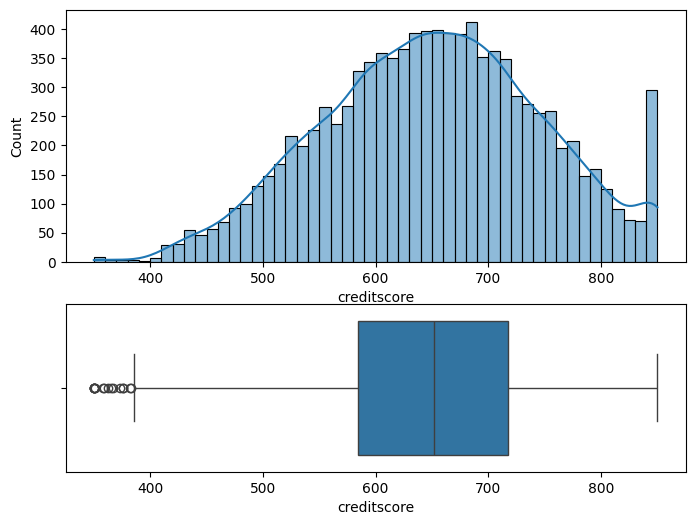




Age



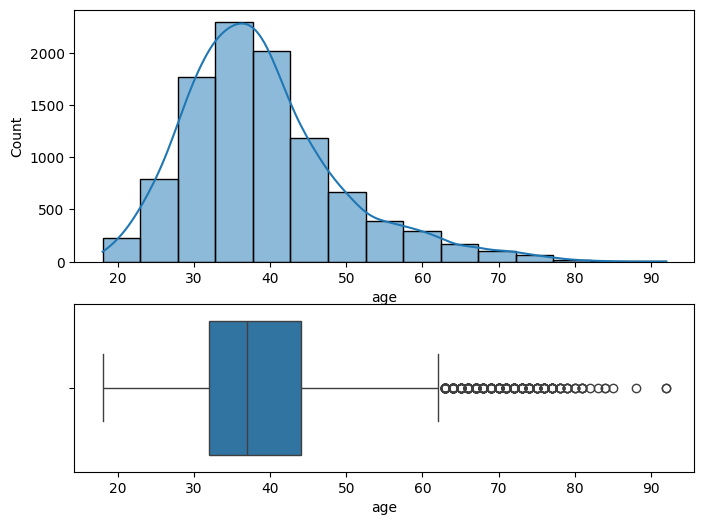




Balance



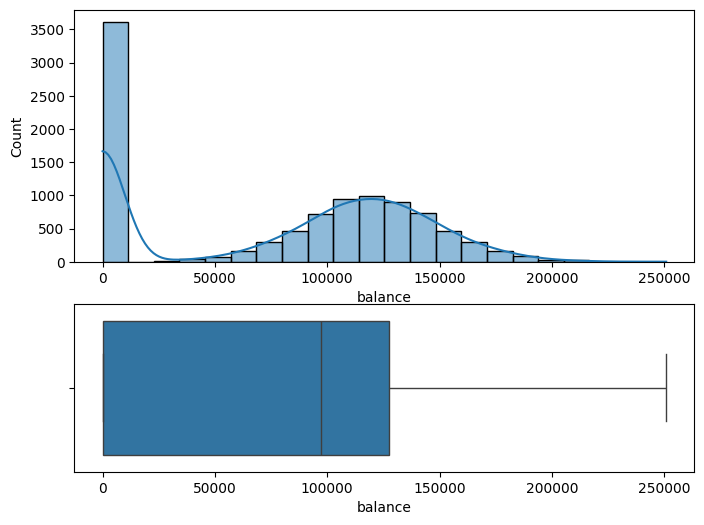




Estimatedsalary



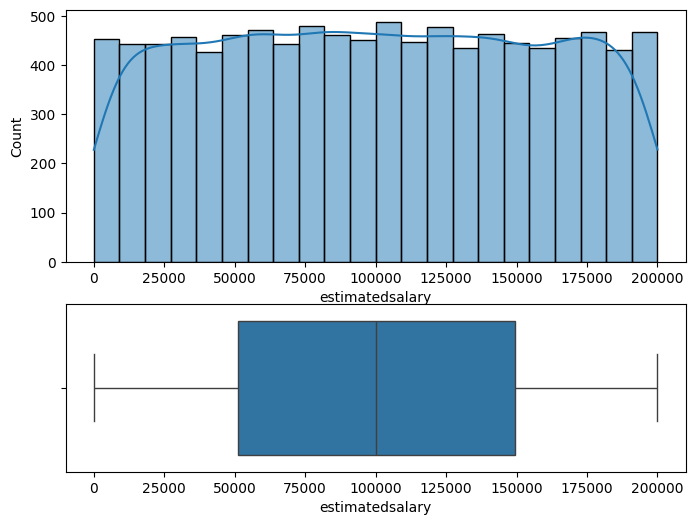

In [34]:
for num_col in numerical_cols:
    print(f"{num_col.title()}", end="\n\n")
    plots_for_numerical_columns(column_name=num_col, bins=col_bins[num_col])
    print("\n\n")

In [35]:
# people with 0 bal

(
    X.loc[
        (X["balance"].eq(0)), :
    ]
)

,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary
0,619,France,Female,42.0,2,0.0,1,1.0,1.0,101348.88
3,699,France,Female,39.0,1,0.0,2,0.0,0.0,93826.63
11,497,Spain,Male,24.0,3,0.0,2,1.0,0.0,76390.01
12,476,France,Female,34.0,10,0.0,2,1.0,0.0,26260.98
13,549,France,Female,25.0,5,0.0,2,0.0,0.0,190857.79
...,...,...,...,...,...,...,...,...,...,...
9989,841,Spain,Male,28.0,4,0.0,2,1.0,1.0,179436.60
9992,726,Spain,Male,36.0,2,0.0,1,1.0,0.0,195192.40
9994,800,France,Female,29.0,2,0.0,2,0.0,0.0,167773.55
9995,771,France,Male,39.0,5,0.0,2,1.0,0.0,96270.64


In [36]:
X["balance"].eq(0)

0         True
1        False
2        False
3         True
5        False
         ...  
9995      True
9996     False
9997      True
9998     False
10000    False
Name: balance, Length: 9996, dtype: bool

In [37]:
# new col for 0 bal customers

X["iszerobal"] = X["balance"].eq(0).astype(int)

In [38]:
X

,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,iszerobal
0,619,France,Female,42.0,2,0.00,1,1.0,1.0,101348.88,1
1,608,Spain,Female,41.0,1,83807.86,1,0.0,1.0,112542.58,0
2,502,France,Female,42.0,8,159660.80,3,1.0,0.0,113931.57,0
3,699,France,Female,39.0,1,0.00,2,0.0,0.0,93826.63,1
5,645,Spain,Male,44.0,8,113755.78,2,1.0,0.0,149756.71,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,771,France,Male,39.0,5,0.00,2,1.0,0.0,96270.64,1
9996,516,France,Male,35.0,10,57369.61,1,1.0,1.0,101699.77,0
9997,709,France,Female,36.0,7,0.00,1,0.0,1.0,42085.58,1
9998,772,Germany,Male,42.0,3,75075.31,2,1.0,0.0,92888.52,0


In [39]:
def plots_for_categorical_cols(column_name):
    display(X[column_name].value_counts(normalize=True))
    print(f"There are {X[column_name].nunique()} unique values in the column {column_name} which are {X[column_name].unique()}")
    # plot the count plot
    sns.countplot(data=X,x=column_name)
    plt.show()

Gender


gender
Male      0.545618
Female    0.454382
Name: proportion, dtype: float64

There are 2 unique values in the column gender which are ['Female' 'Male']


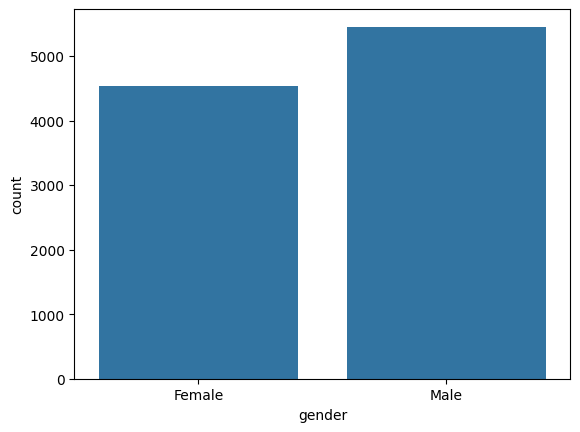




Geography


geography
France     0.501301
Germany    0.251000
Spain      0.247699
Name: proportion, dtype: float64

There are 3 unique values in the column geography which are ['France' 'Spain' 'Germany']


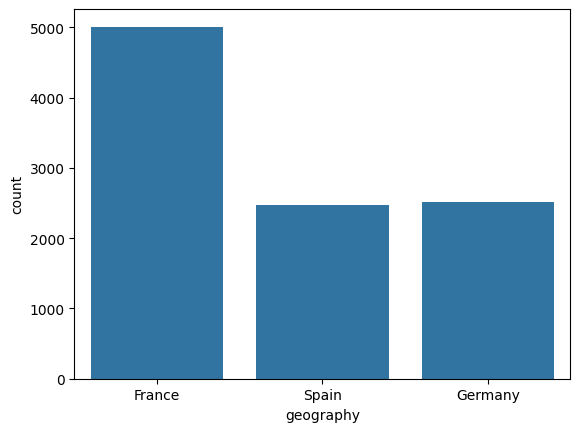

In [40]:
for cat_col in categorical_cols:
    print(f"{cat_col.title()}")
    plots_for_categorical_cols(cat_col)
    print("\n\n")

In [41]:
X

,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,iszerobal
0,619,France,Female,42.0,2,0.00,1,1.0,1.0,101348.88,1
1,608,Spain,Female,41.0,1,83807.86,1,0.0,1.0,112542.58,0
2,502,France,Female,42.0,8,159660.80,3,1.0,0.0,113931.57,0
3,699,France,Female,39.0,1,0.00,2,0.0,0.0,93826.63,1
5,645,Spain,Male,44.0,8,113755.78,2,1.0,0.0,149756.71,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,771,France,Male,39.0,5,0.00,2,1.0,0.0,96270.64,1
9996,516,France,Male,35.0,10,57369.61,1,1.0,1.0,101699.77,0
9997,709,France,Female,36.0,7,0.00,1,0.0,1.0,42085.58,1
9998,772,Germany,Male,42.0,3,75075.31,2,1.0,0.0,92888.52,0


In [42]:
# distribution of target

y.value_counts(normalize=True)

exited
0    0.796218
1    0.203782
Name: proportion, dtype: float64

## FE and Model training

In [43]:
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

In [44]:
# split the data

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=30,stratify=y)

In [45]:
print(f"The shape of training data is {X_train.shape}")
print(f"The shape of test data is {X_test.shape}")

The shape of training data is (7996, 11)
The shape of test data is (2000, 11)


In [46]:
# column transformer

scaler = MinMaxScaler()

encoder = OneHotEncoder(handle_unknown="ignore",sparse_output=False)

preprocessor = ColumnTransformer(transformers=[
    ("scaler",scaler,numerical_cols),
    ("encoder",encoder,categorical_cols)
], remainder="passthrough",verbose_feature_names_out=False)

In [47]:
preprocessor

,transformers,"[('scaler', ...), ('encoder', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,False
,force_int_remainder_cols,'deprecated'
,feature_range,"(0, ...)"
,copy,True
,clip,False


In [48]:
# apply the transformation

X_train = preprocessor.fit_transform(X_train)

X_test = preprocessor.transform(X_test)

In [49]:
X_train

,creditscore,age,balance,estimatedsalary,gender_Female,gender_Male,geography_France,geography_Germany,geography_Spain,tenure,numofproducts,hascrcard,isactivemember,iszerobal
5582,0.368,0.270270,0.000000,0.719780,0.0,1.0,1.0,0.0,0.0,3,1,0.0,0.0,1
2549,0.590,0.243243,0.000000,0.060437,1.0,0.0,1.0,0.0,0.0,8,2,1.0,1.0,1
7202,0.446,0.729730,0.393649,0.480118,1.0,0.0,0.0,0.0,1.0,8,1,1.0,1.0,0
2523,0.812,0.081081,0.000000,0.921041,1.0,0.0,1.0,0.0,0.0,1,2,1.0,0.0,1
9655,0.466,0.297297,0.222307,0.134572,1.0,0.0,1.0,0.0,0.0,4,2,1.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9709,0.450,0.527027,0.549773,0.422404,1.0,0.0,1.0,0.0,0.0,8,1,1.0,1.0,0
4978,0.380,0.229730,0.509378,0.421225,0.0,1.0,0.0,1.0,0.0,7,1,0.0,1.0,0
3618,0.278,0.378378,0.366922,0.736207,1.0,0.0,0.0,1.0,0.0,8,1,1.0,0.0,0
5671,0.786,0.743243,0.000000,0.539389,1.0,0.0,1.0,0.0,0.0,6,2,0.0,1.0,1


In [50]:
X_test

,creditscore,age,balance,estimatedsalary,gender_Female,gender_Male,geography_France,geography_Germany,geography_Spain,tenure,numofproducts,hascrcard,isactivemember,iszerobal
9170,0.688,0.162162,0.000000,0.075154,0.0,1.0,1.0,0.0,0.0,2,3,0.0,1.0,1
5072,0.244,0.148649,0.408494,0.906250,0.0,1.0,1.0,0.0,0.0,8,1,0.0,1.0,0
8108,0.174,0.229730,0.505398,0.805774,0.0,1.0,0.0,1.0,0.0,6,2,1.0,1.0,0
2560,0.600,0.162162,0.000000,0.339997,1.0,0.0,0.0,0.0,1.0,6,1,0.0,0.0,1
5199,0.864,0.121622,0.000000,0.718159,1.0,0.0,0.0,0.0,1.0,3,2,1.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
618,0.392,0.324324,0.554291,0.434756,0.0,1.0,0.0,0.0,1.0,7,1,1.0,1.0,0
455,0.312,0.243243,0.000000,0.821377,0.0,1.0,1.0,0.0,0.0,5,2,1.0,0.0,1
4095,0.760,0.594595,0.447118,0.307574,0.0,1.0,0.0,0.0,1.0,5,1,0.0,1.0,0
1009,0.600,0.716216,0.000000,0.877025,0.0,1.0,0.0,0.0,1.0,0,1,1.0,1.0,1


### Model Building

In [51]:
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

In [52]:
from sklearn.ensemble import VotingClassifier

In [53]:
# define models

rf = RandomForestClassifier(class_weight="balanced", random_state=42)

xgb = XGBClassifier(class_weight="balanced", random_state=42)

lgbm = LGBMClassifier(class_weight="balanced", random_state=42)

In [54]:
# build a voting classifier

model = VotingClassifier(estimators=[
    ("rf",rf),
    ("xgb",xgb),
    ("lgbm",lgbm)
], voting="soft",n_jobs=-1)

model

,estimators,"[('rf', ...), ('xgb', ...), ...]"
,voting,'soft'
,weights,None
,n_jobs,-1
,flatten_transform,True
,verbose,False
,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1


In [55]:
# fit the model on the dataset

model.fit(X_train, y_train)

,estimators,"[('rf', ...), ('xgb', ...), ...]"
,voting,'soft'
,weights,None
,n_jobs,-1
,flatten_transform,True
,verbose,False
,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1


In [56]:
# get the predictions

y_pred = model.predict(X_test)

In [57]:
model.predict_proba(X_test.iloc[0:5,:])

array([[0.66581442, 0.33418559],
       [0.95182903, 0.04817097],
       [0.9513067 , 0.04869331],
       [0.73605231, 0.26394769],
       [0.96801903, 0.03198098]])

In [58]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.95      0.92      1592
           1       0.73      0.58      0.65       408

    accuracy                           0.87      2000
   macro avg       0.82      0.76      0.78      2000
weighted avg       0.86      0.87      0.87      2000



#### HP Tuning

In [59]:
import optuna
from sklearn.model_selection import cross_val_score, StratifiedKFold

In [60]:
model

,estimators,"[('rf', ...), ('xgb', ...), ...]"
,voting,'soft'
,weights,None
,n_jobs,-1
,flatten_transform,True
,verbose,False
,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1


In [61]:
model.estimators

[('rf', RandomForestClassifier(class_weight='balanced', random_state=42)),
 ('xgb',
  XGBClassifier(base_score=None, booster=None, callbacks=None,
                class_weight='balanced', colsample_bylevel=None,
                colsample_bynode=None, colsample_bytree=None, device=None,
                early_stopping_rounds=None, enable_categorical=False,
                eval_metric=None, feature_types=None, feature_weights=None,
                gamma=None, grow_policy=None, importance_type=None,
                interaction_constraints=None, learning_rate=None, max_bin=None,
                max_cat_threshold=None, max_cat_to_onehot=None,
                max_delta_step=None, max_depth=None, max_leaves=None,
                min_child_weight=None, missing=nan, monotone_constraints=None,
                multi_strategy=None, n_estimators=None, n_jobs=None, ...)),
 ('lgbm', LGBMClassifier(class_weight='balanced', random_state=42))]

In [62]:
def objective(trial: optuna.Trial):
    
    params_dict = {
        "rf__n_estimators": trial.suggest_int("rf__n_estimators", 50, 200),
        "rf__max_depth": trial.suggest_int("rf__max_depth", 5, 12),
        "rf__max_samples": trial.suggest_float("rf__max_samples", 0.5, 1.0),
        "xgb__learning_rate": trial.suggest_float("xgb__learning_rate", 0.01, 0.5),
        "xgb__max_depth": trial.suggest_int("xgb__max_depth", 5, 15),
        "xgb__n_estimators": trial.suggest_int("xgb__n_estimators", 30, 200),
        "xgb__subsample": trial.suggest_float("xgb__subsample", 0.5,1.0),
        "xgb__colsample_bynode": trial.suggest_float("xgb__colsample_bynode", 0.7, 1.0),
        "xgb__reg_lambda": trial.suggest_float("xgb__reg_lambda",0.1,10.0),
        "lgbm__max_depth": trial.suggest_int("lgbm__max_depth", 5, 15),
        "lgbm__n_estimators": trial.suggest_int("lgbm__n_estimators", 30, 200),
        "lgbm__learning_rate": trial.suggest_float("lgbm__learning_rate", 0.01, 0.5),
        "lgbm__subsample": trial.suggest_float("lgbm__subsample", 0.5,1.0),
        "lgbm__reg_lambda": trial.suggest_float("lgbm__reg_lambda",0.1,10.0)
    }
    
    # define models
    rf = RandomForestClassifier(class_weight="balanced", random_state=42)
    xgb = XGBClassifier(class_weight="balanced", random_state=42)
    lgbm = LGBMClassifier(class_weight="balanced", random_state=42)
    
    # build a voting classifier
    model = VotingClassifier(estimators=[
        ("rf",rf),
        ("xgb",xgb),
        ("lgbm",lgbm)
    ], voting="soft",n_jobs=-1)
    
    # pass parameters to model
    model.set_params(**params_dict)
    
    # cross validation
    scores = cross_val_score(estimator=model,
                             X=X_train, y=y_train,
                             scoring="f1", 
                             cv=StratifiedKFold(n_splits=5,random_state=10,shuffle=True),
                             n_jobs=-1)
    
    # mean f1
    mean_f1 = np.mean(scores)
    
    return mean_f1

In [63]:
# define my study

study = optuna.create_study(direction="maximize")

study.optimize(func=objective,n_trials=20,n_jobs=-1,show_progress_bar=True)

[I 2025-09-14 23:32:27,500] A new study created in memory with name: no-name-1cc7ccc3-1abf-4ad3-b3c6-e3acf4f4325b
Best trial: 0. Best value: 0.60067:   5%|▌         | 1/20 [00:20<06:37, 20.92s/it]

[I 2025-09-14 23:32:48,411] Trial 0 finished with value: 0.6006699113338848 and parameters: {'rf__n_estimators': 144, 'rf__max_depth': 12, 'rf__max_samples': 0.577447846608184, 'xgb__learning_rate': 0.40907710023675875, 'xgb__max_depth': 11, 'xgb__n_estimators': 137, 'xgb__subsample': 0.8283173908346159, 'xgb__colsample_bynode': 0.8471394659694754, 'xgb__reg_lambda': 3.9906386607710798, 'lgbm__max_depth': 13, 'lgbm__n_estimators': 82, 'lgbm__learning_rate': 0.2368673161627927, 'lgbm__subsample': 0.7178077663607462, 'lgbm__reg_lambda': 5.267458533480163}. Best is trial 0 with value: 0.6006699113338848.


Best trial: 1. Best value: 0.606245:  10%|█         | 2/20 [00:23<03:03, 10.18s/it]

[I 2025-09-14 23:32:51,069] Trial 1 finished with value: 0.606245481383634 and parameters: {'rf__n_estimators': 75, 'rf__max_depth': 7, 'rf__max_samples': 0.8436025134463179, 'xgb__learning_rate': 0.24477100504984559, 'xgb__max_depth': 5, 'xgb__n_estimators': 189, 'xgb__subsample': 0.7199771392964454, 'xgb__colsample_bynode': 0.8031012523892065, 'xgb__reg_lambda': 2.9908362080249047, 'lgbm__max_depth': 14, 'lgbm__n_estimators': 136, 'lgbm__learning_rate': 0.31567432012047375, 'lgbm__subsample': 0.8359977676549823, 'lgbm__reg_lambda': 8.456462516819204}. Best is trial 1 with value: 0.606245481383634.


Best trial: 3. Best value: 0.61225:  15%|█▌        | 3/20 [00:31<02:35,  9.12s/it] 

[I 2025-09-14 23:32:58,923] Trial 3 finished with value: 0.612249730227376 and parameters: {'rf__n_estimators': 193, 'rf__max_depth': 9, 'rf__max_samples': 0.8657491574695945, 'xgb__learning_rate': 0.4638935322601867, 'xgb__max_depth': 5, 'xgb__n_estimators': 46, 'xgb__subsample': 0.8430809377752296, 'xgb__colsample_bynode': 0.8176864003717114, 'xgb__reg_lambda': 3.666363628175511, 'lgbm__max_depth': 10, 'lgbm__n_estimators': 53, 'lgbm__learning_rate': 0.06700583908425163, 'lgbm__subsample': 0.5147070891077525, 'lgbm__reg_lambda': 3.866381037819614}. Best is trial 3 with value: 0.612249730227376.


Best trial: 3. Best value: 0.61225:  20%|██        | 4/20 [00:34<01:48,  6.79s/it]

[I 2025-09-14 23:33:02,161] Trial 2 finished with value: 0.6029083990603091 and parameters: {'rf__n_estimators': 172, 'rf__max_depth': 5, 'rf__max_samples': 0.7705081756879564, 'xgb__learning_rate': 0.2754997262337627, 'xgb__max_depth': 11, 'xgb__n_estimators': 167, 'xgb__subsample': 0.9504925152419881, 'xgb__colsample_bynode': 0.8317844387028736, 'xgb__reg_lambda': 8.051858035440691, 'lgbm__max_depth': 7, 'lgbm__n_estimators': 70, 'lgbm__learning_rate': 0.09498375594654804, 'lgbm__subsample': 0.5581073199119564, 'lgbm__reg_lambda': 2.716130057371443}. Best is trial 3 with value: 0.612249730227376.


Best trial: 3. Best value: 0.61225:  25%|██▌       | 5/20 [00:44<01:57,  7.85s/it]

[I 2025-09-14 23:33:11,878] Trial 4 finished with value: 0.6051148615821192 and parameters: {'rf__n_estimators': 128, 'rf__max_depth': 6, 'rf__max_samples': 0.6231562510342916, 'xgb__learning_rate': 0.32028833688317176, 'xgb__max_depth': 11, 'xgb__n_estimators': 89, 'xgb__subsample': 0.6870741514433408, 'xgb__colsample_bynode': 0.8735945610527746, 'xgb__reg_lambda': 0.501708026963762, 'lgbm__max_depth': 7, 'lgbm__n_estimators': 160, 'lgbm__learning_rate': 0.037507613408958064, 'lgbm__subsample': 0.567773536333281, 'lgbm__reg_lambda': 7.318511079195458}. Best is trial 3 with value: 0.612249730227376.


Best trial: 3. Best value: 0.61225:  30%|███       | 6/20 [00:44<01:15,  5.37s/it]

[I 2025-09-14 23:33:12,431] Trial 5 finished with value: 0.5960564286416219 and parameters: {'rf__n_estimators': 120, 'rf__max_depth': 5, 'rf__max_samples': 0.9923862789363505, 'xgb__learning_rate': 0.37250694946931495, 'xgb__max_depth': 6, 'xgb__n_estimators': 155, 'xgb__subsample': 0.5411975486216137, 'xgb__colsample_bynode': 0.7305259159521935, 'xgb__reg_lambda': 7.253368516058746, 'lgbm__max_depth': 8, 'lgbm__n_estimators': 82, 'lgbm__learning_rate': 0.40885729006817056, 'lgbm__subsample': 0.8168721588861242, 'lgbm__reg_lambda': 1.7517890259016615}. Best is trial 3 with value: 0.612249730227376.


Best trial: 3. Best value: 0.61225:  35%|███▌      | 7/20 [00:57<01:40,  7.71s/it]

[I 2025-09-14 23:33:24,952] Trial 6 finished with value: 0.5951253311200622 and parameters: {'rf__n_estimators': 51, 'rf__max_depth': 6, 'rf__max_samples': 0.7793012680831481, 'xgb__learning_rate': 0.4825602939262945, 'xgb__max_depth': 10, 'xgb__n_estimators': 34, 'xgb__subsample': 0.8834948441183912, 'xgb__colsample_bynode': 0.9439679018793046, 'xgb__reg_lambda': 2.112613920367243, 'lgbm__max_depth': 10, 'lgbm__n_estimators': 52, 'lgbm__learning_rate': 0.44773320067069905, 'lgbm__subsample': 0.6943589232252183, 'lgbm__reg_lambda': 0.21728362708566407}. Best is trial 3 with value: 0.612249730227376.


Best trial: 3. Best value: 0.61225:  40%|████      | 8/20 [01:02<01:24,  7.01s/it]

[I 2025-09-14 23:33:30,460] Trial 7 finished with value: 0.6045509480576421 and parameters: {'rf__n_estimators': 125, 'rf__max_depth': 8, 'rf__max_samples': 0.934136865433997, 'xgb__learning_rate': 0.25319983558597736, 'xgb__max_depth': 11, 'xgb__n_estimators': 153, 'xgb__subsample': 0.852252537988365, 'xgb__colsample_bynode': 0.946034493261638, 'xgb__reg_lambda': 7.2647350211681685, 'lgbm__max_depth': 12, 'lgbm__n_estimators': 105, 'lgbm__learning_rate': 0.17802076779824222, 'lgbm__subsample': 0.777348338331245, 'lgbm__reg_lambda': 4.038508213774084}. Best is trial 3 with value: 0.612249730227376.


Best trial: 3. Best value: 0.61225:  45%|████▌     | 9/20 [01:13<01:30,  8.20s/it]

[I 2025-09-14 23:33:41,268] Trial 8 finished with value: 0.5967264031675135 and parameters: {'rf__n_estimators': 95, 'rf__max_depth': 10, 'rf__max_samples': 0.6341910893729545, 'xgb__learning_rate': 0.21160173403398563, 'xgb__max_depth': 9, 'xgb__n_estimators': 38, 'xgb__subsample': 0.9301875438509372, 'xgb__colsample_bynode': 0.9019017043905982, 'xgb__reg_lambda': 9.54588008619129, 'lgbm__max_depth': 9, 'lgbm__n_estimators': 137, 'lgbm__learning_rate': 0.41943527511321826, 'lgbm__subsample': 0.9533492772284131, 'lgbm__reg_lambda': 2.9849200124840665}. Best is trial 3 with value: 0.612249730227376.


Best trial: 3. Best value: 0.61225:  50%|█████     | 10/20 [01:16<01:04,  6.44s/it]

[I 2025-09-14 23:33:43,778] Trial 9 finished with value: 0.5988718357580022 and parameters: {'rf__n_estimators': 192, 'rf__max_depth': 12, 'rf__max_samples': 0.8233278560224766, 'xgb__learning_rate': 0.39644688936003164, 'xgb__max_depth': 14, 'xgb__n_estimators': 197, 'xgb__subsample': 0.8433029875665113, 'xgb__colsample_bynode': 0.9519777236371418, 'xgb__reg_lambda': 4.833938405765287, 'lgbm__max_depth': 6, 'lgbm__n_estimators': 83, 'lgbm__learning_rate': 0.4939565414082186, 'lgbm__subsample': 0.7520701174177755, 'lgbm__reg_lambda': 8.042917679939302}. Best is trial 3 with value: 0.612249730227376.


Best trial: 3. Best value: 0.61225:  55%|█████▌    | 11/20 [01:27<01:10,  7.87s/it]

[I 2025-09-14 23:33:54,898] Trial 10 finished with value: 0.5995142602905182 and parameters: {'rf__n_estimators': 167, 'rf__max_depth': 8, 'rf__max_samples': 0.8945214951614244, 'xgb__learning_rate': 0.33245447173503384, 'xgb__max_depth': 12, 'xgb__n_estimators': 71, 'xgb__subsample': 0.8064679676132747, 'xgb__colsample_bynode': 0.8584151613984081, 'xgb__reg_lambda': 1.0008996423054093, 'lgbm__max_depth': 10, 'lgbm__n_estimators': 90, 'lgbm__learning_rate': 0.26984259456431314, 'lgbm__subsample': 0.9134288994043485, 'lgbm__reg_lambda': 0.5872608888797555}. Best is trial 3 with value: 0.612249730227376.


Best trial: 3. Best value: 0.61225:  60%|██████    | 12/20 [01:29<00:49,  6.24s/it]

[I 2025-09-14 23:33:57,420] Trial 11 finished with value: 0.6093931476170183 and parameters: {'rf__n_estimators': 144, 'rf__max_depth': 7, 'rf__max_samples': 0.7082867422777432, 'xgb__learning_rate': 0.23353161191950395, 'xgb__max_depth': 10, 'xgb__n_estimators': 83, 'xgb__subsample': 0.9462374516687626, 'xgb__colsample_bynode': 0.752165681507927, 'xgb__reg_lambda': 9.325103919993197, 'lgbm__max_depth': 15, 'lgbm__n_estimators': 48, 'lgbm__learning_rate': 0.22280588499767526, 'lgbm__subsample': 0.69769110294772, 'lgbm__reg_lambda': 6.0021761031533005}. Best is trial 3 with value: 0.612249730227376.


Best trial: 3. Best value: 0.61225:  65%|██████▌   | 13/20 [01:40<00:52,  7.49s/it]

[I 2025-09-14 23:34:07,773] Trial 12 finished with value: 0.6029189690261864 and parameters: {'rf__n_estimators': 138, 'rf__max_depth': 9, 'rf__max_samples': 0.6560072064018627, 'xgb__learning_rate': 0.4599787600208739, 'xgb__max_depth': 12, 'xgb__n_estimators': 47, 'xgb__subsample': 0.8386049106258939, 'xgb__colsample_bynode': 0.8542274521871618, 'xgb__reg_lambda': 5.789105073629623, 'lgbm__max_depth': 6, 'lgbm__n_estimators': 104, 'lgbm__learning_rate': 0.15403611622508687, 'lgbm__subsample': 0.6310942055163589, 'lgbm__reg_lambda': 3.7271329969663576}. Best is trial 3 with value: 0.612249730227376.


Best trial: 13. Best value: 0.612975:  70%|███████   | 14/20 [01:44<00:38,  6.37s/it]

[I 2025-09-14 23:34:11,519] Trial 13 finished with value: 0.6129747895173303 and parameters: {'rf__n_estimators': 195, 'rf__max_depth': 10, 'rf__max_samples': 0.8805567053977201, 'xgb__learning_rate': 0.06685025433638456, 'xgb__max_depth': 7, 'xgb__n_estimators': 83, 'xgb__subsample': 0.6013887614123441, 'xgb__colsample_bynode': 0.7543616488537217, 'xgb__reg_lambda': 0.3035029857732714, 'lgbm__max_depth': 11, 'lgbm__n_estimators': 37, 'lgbm__learning_rate': 0.14820462660376765, 'lgbm__subsample': 0.5026408302243598, 'lgbm__reg_lambda': 5.771778589632299}. Best is trial 13 with value: 0.6129747895173303.


Best trial: 14. Best value: 0.617649:  75%|███████▌  | 15/20 [01:46<00:25,  5.10s/it]

[I 2025-09-14 23:34:13,703] Trial 14 finished with value: 0.6176490735438483 and parameters: {'rf__n_estimators': 68, 'rf__max_depth': 10, 'rf__max_samples': 0.8707131045923506, 'xgb__learning_rate': 0.046162394710294874, 'xgb__max_depth': 5, 'xgb__n_estimators': 96, 'xgb__subsample': 0.6969617839917116, 'xgb__colsample_bynode': 0.7689129796606394, 'xgb__reg_lambda': 2.9990856444473883, 'lgbm__max_depth': 15, 'lgbm__n_estimators': 36, 'lgbm__learning_rate': 0.3182479223963631, 'lgbm__subsample': 0.86177882867824, 'lgbm__reg_lambda': 9.523973690462338}. Best is trial 14 with value: 0.6176490735438483.


Best trial: 14. Best value: 0.617649:  80%|████████  | 16/20 [01:54<00:24,  6.07s/it]

[I 2025-09-14 23:34:22,012] Trial 15 finished with value: 0.6158375469005166 and parameters: {'rf__n_estimators': 198, 'rf__max_depth': 10, 'rf__max_samples': 0.6942914841820766, 'xgb__learning_rate': 0.0939826838234038, 'xgb__max_depth': 7, 'xgb__n_estimators': 74, 'xgb__subsample': 0.9989136338951146, 'xgb__colsample_bynode': 0.7428434875748103, 'xgb__reg_lambda': 6.130630161790981, 'lgbm__max_depth': 15, 'lgbm__n_estimators': 32, 'lgbm__learning_rate': 0.13879975834825103, 'lgbm__subsample': 0.6354706274721534, 'lgbm__reg_lambda': 6.065488164198875}. Best is trial 14 with value: 0.6176490735438483.


Best trial: 14. Best value: 0.617649:  85%|████████▌ | 17/20 [02:02<00:19,  6.51s/it]

[I 2025-09-14 23:34:29,573] Trial 16 finished with value: 0.6141411792059481 and parameters: {'rf__n_estimators': 199, 'rf__max_depth': 10, 'rf__max_samples': 0.5005578710528902, 'xgb__learning_rate': 0.11610348646118775, 'xgb__max_depth': 7, 'xgb__n_estimators': 106, 'xgb__subsample': 0.9981343858806366, 'xgb__colsample_bynode': 0.7540594738593964, 'xgb__reg_lambda': 9.358666827236139, 'lgbm__max_depth': 15, 'lgbm__n_estimators': 30, 'lgbm__learning_rate': 0.015453121282549151, 'lgbm__subsample': 0.5008059725499852, 'lgbm__reg_lambda': 5.9982858568672945}. Best is trial 14 with value: 0.6176490735438483.


Best trial: 14. Best value: 0.617649:  90%|█████████ | 18/20 [02:10<00:14,  7.03s/it]

[I 2025-09-14 23:34:37,806] Trial 17 finished with value: 0.6083235444433377 and parameters: {'rf__n_estimators': 200, 'rf__max_depth': 10, 'rf__max_samples': 0.9086991278289214, 'xgb__learning_rate': 0.08009924709950349, 'xgb__max_depth': 7, 'xgb__n_estimators': 112, 'xgb__subsample': 0.6222107304402115, 'xgb__colsample_bynode': 0.776429534666976, 'xgb__reg_lambda': 2.1013441172574043, 'lgbm__max_depth': 12, 'lgbm__n_estimators': 33, 'lgbm__learning_rate': 0.011099022679696341, 'lgbm__subsample': 0.5010633398418112, 'lgbm__reg_lambda': 6.249202040179752}. Best is trial 14 with value: 0.6176490735438483.


Best trial: 14. Best value: 0.617649:  95%|█████████▌| 19/20 [02:22<00:08,  8.62s/it]

[I 2025-09-14 23:34:50,136] Trial 18 finished with value: 0.5996559962606269 and parameters: {'rf__n_estimators': 96, 'rf__max_depth': 11, 'rf__max_samples': 0.9638052520684489, 'xgb__learning_rate': 0.029545801716859162, 'xgb__max_depth': 7, 'xgb__n_estimators': 111, 'xgb__subsample': 0.607918044604223, 'xgb__colsample_bynode': 0.7001286661684183, 'xgb__reg_lambda': 1.9057237243275282, 'lgbm__max_depth': 12, 'lgbm__n_estimators': 199, 'lgbm__learning_rate': 0.33735091337771017, 'lgbm__subsample': 0.9067088645008347, 'lgbm__reg_lambda': 9.624514288792644}. Best is trial 14 with value: 0.6176490735438483.


Best trial: 14. Best value: 0.617649: 100%|██████████| 20/20 [02:27<00:00,  7.37s/it]

[I 2025-09-14 23:34:54,855] Trial 19 finished with value: 0.6016129223554818 and parameters: {'rf__n_estimators': 97, 'rf__max_depth': 10, 'rf__max_samples': 0.5016040213662337, 'xgb__learning_rate': 0.012545401861350308, 'xgb__max_depth': 8, 'xgb__n_estimators': 101, 'xgb__subsample': 0.6656736354532768, 'xgb__colsample_bynode': 0.7044105213647873, 'xgb__reg_lambda': 5.739687686323159, 'lgbm__max_depth': 15, 'lgbm__n_estimators': 198, 'lgbm__learning_rate': 0.3362013931477383, 'lgbm__subsample': 0.8865080629485492, 'lgbm__reg_lambda': 9.427910648782287}. Best is trial 14 with value: 0.6176490735438483.


In [64]:
# best parameters

study.best_params

{'rf__n_estimators': 68,
 'rf__max_depth': 10,
 'rf__max_samples': 0.8707131045923506,
 'xgb__learning_rate': 0.046162394710294874,
 'xgb__max_depth': 5,
 'xgb__n_estimators': 96,
 'xgb__subsample': 0.6969617839917116,
 'xgb__colsample_bynode': 0.7689129796606394,
 'xgb__reg_lambda': 2.9990856444473883,
 'lgbm__max_depth': 15,
 'lgbm__n_estimators': 36,
 'lgbm__learning_rate': 0.3182479223963631,
 'lgbm__subsample': 0.86177882867824,
 'lgbm__reg_lambda': 9.523973690462338}

In [65]:
best_params = study.best_params

In [66]:
# best score
study.best_value

0.6176490735438483

In [67]:
# define models
rf = RandomForestClassifier(class_weight="balanced", random_state=42)
xgb = XGBClassifier(class_weight="balanced", random_state=42)
lgbm = LGBMClassifier(class_weight="balanced", random_state=42)
    
# build a voting classifier
model = VotingClassifier(estimators=[
    ("rf",rf),
    ("xgb",xgb),
    ("lgbm",lgbm)
], voting="soft",n_jobs=-1)

# pass the best params to model
model.set_params(**best_params)

model

,estimators,"[('rf', ...), ('xgb', ...), ...]"
,voting,'soft'
,weights,None
,n_jobs,-1
,flatten_transform,True
,verbose,False
,n_estimators,68
,criterion,'gini'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,1


In [68]:
# train the model

model.fit(X_train,y_train)

,estimators,"[('rf', ...), ('xgb', ...), ...]"
,voting,'soft'
,weights,None
,n_jobs,-1
,flatten_transform,True
,verbose,False
,n_estimators,68
,criterion,'gini'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,1


In [69]:
# get the predictions
y_pred = model.predict(X_test)

In [70]:
model.predict_proba(X_test.iloc[0:3, :])

array([[0.71653407, 0.28346592],
       [0.87356252, 0.12643748],
       [0.88682084, 0.11317916]])

In [71]:
# classification report

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.90      0.93      0.91      1592
           1       0.68      0.62      0.65       408

    accuracy                           0.86      2000
   macro avg       0.79      0.77      0.78      2000
weighted avg       0.86      0.86      0.86      2000



## SHAP

In [72]:
# make the explainer

explainer = shap.TreeExplainer(model=model,
                               data=X_train,
                               model_output="probability")

InvalidModelError: Model type not yet supported by TreeExplainer: <class 'sklearn.ensemble._voting.VotingClassifier'>

In [73]:
model

,estimators,"[('rf', ...), ('xgb', ...), ...]"
,voting,'soft'
,weights,None
,n_jobs,-1
,flatten_transform,True
,verbose,False
,n_estimators,68
,criterion,'gini'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,1


In [74]:
model.predict_proba(X_test.iloc[0:3])[:,1]

array([0.28346592, 0.12643748, 0.11317916])

In [75]:
def prediction_fn(X):
    predictions = model.predict_proba(X)[:,1]
    return predictions

In [76]:
# model agnostic explainer

explainer = shap.Explainer(model=prediction_fn,
                           masker=X_train,
                           link=shap.links.identity)

In [77]:
X_train.shape[1]

14

In [78]:
# calculate the shap values

shap_values = explainer(X_test.iloc[[1],:])

shap_values

PermutationExplainer explainer: 2it [00:47, 47.15s/it]               


.values =
array([[-0.01572065, -0.14165961, -0.02565038,  0.02896055, -0.01646256,
        -0.0043798 , -0.00073588, -0.02861425,  0.00153599, -0.00908377,
         0.02059432,  0.00601532, -0.02305811,  0.00081553]])

.base_values =
array([0.33388078])

.data =
array([[0.244     , 0.14864865, 0.40849362, 0.90624996, 0.        ,
        1.        , 1.        , 0.        , 0.        , 8.        ,
        1.        , 0.        , 1.        , 0.        ]])

In [79]:
shap_values.shape

(1, 14)

In [80]:
model.predict_proba(X_test.iloc[[1],:])[:,1]

array([0.12643748])

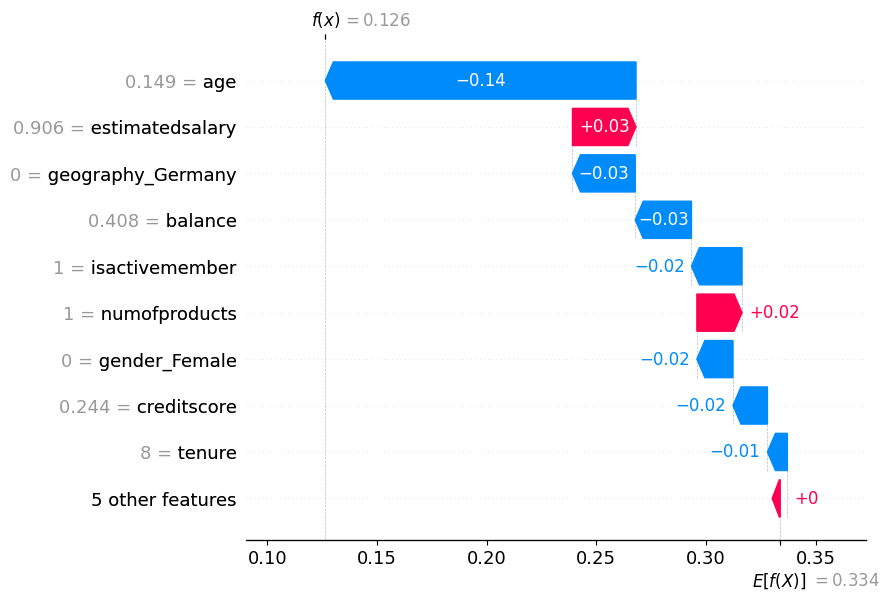

In [81]:
shap.plots.waterfall(shap_values[0])

In [82]:
X_train.shape

(7996, 14)

In [83]:
X_test.shape

(2000, 14)

In [84]:
# sample 500 rows from test data

test_data_sample = X_test.sample(500)

In [85]:
test_data_sample.shape

(500, 14)

In [86]:
# calculate shap values for the entire test data

shap_values = explainer(test_data_sample)

PermutationExplainer explainer: 501it [14:08,  1.71s/it]                         


In [87]:
shap_values.shape

(500, 14)

In [88]:
shap_values

.values =
array([[ 0.00526642,  0.14058209,  0.0249203 , ...,  0.00128323,
         0.08320516,  0.00597139],
       [-0.00347764,  0.24951399,  0.00110012, ..., -0.00222332,
        -0.07327586,  0.00105787],
       [-0.00207816,  0.00175448,  0.03019433, ...,  0.00083186,
         0.05497997,  0.00640163],
       ...,
       [ 0.00432785, -0.09654469, -0.02601877, ..., -0.00032795,
        -0.01660268, -0.0148333 ],
       [-0.00694105, -0.07209541, -0.04368332, ...,  0.00032242,
         0.03727437, -0.0237502 ],
       [-0.00876317, -0.02921637, -0.0398196 , ...,  0.00231205,
         0.06777312,  0.0039216 ]], shape=(500, 14))

.base_values =
array([0.33388078, 0.33388078, 0.33388078, 0.33388078, 0.33388078,
       0.33388078, 0.33388078, 0.33388078, 0.33388078, 0.33388078,
       0.33388078, 0.33388078, 0.33388078, 0.33388078, 0.33388078,
       0.33388078, 0.33388078, 0.33388078, 0.33388078, 0.33388078,
       0.33388078, 0.33388078, 0.33388078, 0.33388078, 0.33388078,
       0.

### Global Plots

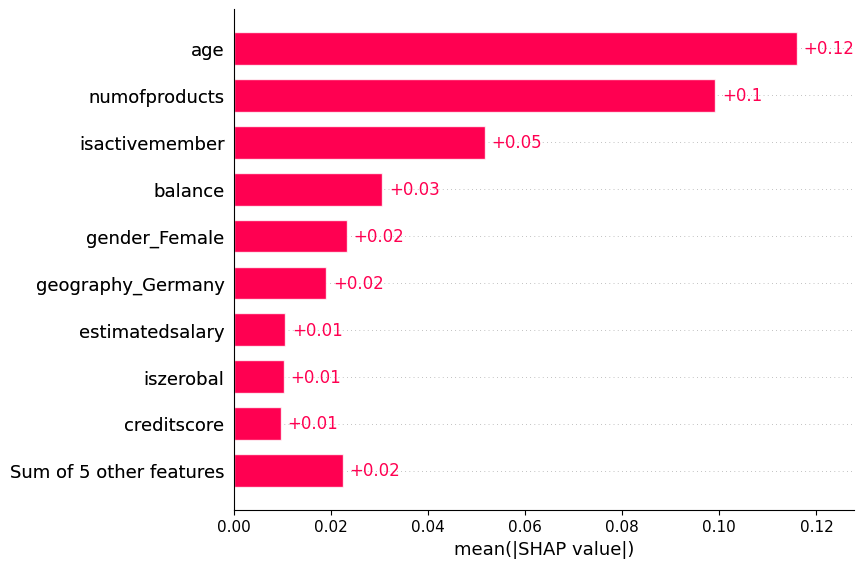

In [89]:
# bar plot

shap.plots.bar(shap_values)

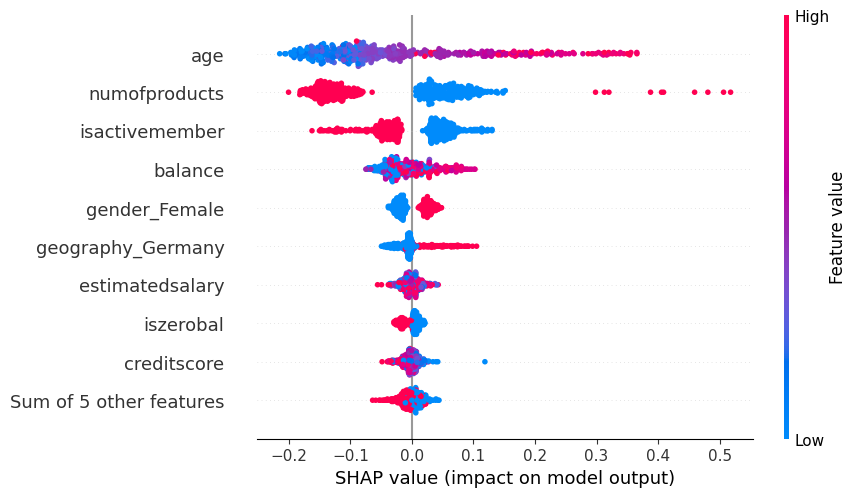

In [90]:
# summary plot

shap.plots.beeswarm(shap_values)

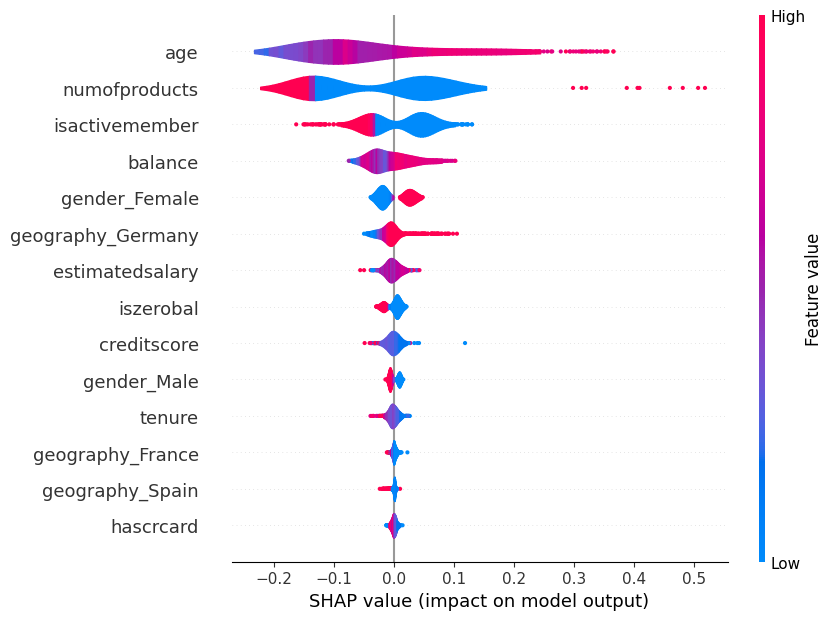

In [91]:
# violin plot

shap.plots.violin(shap_values)

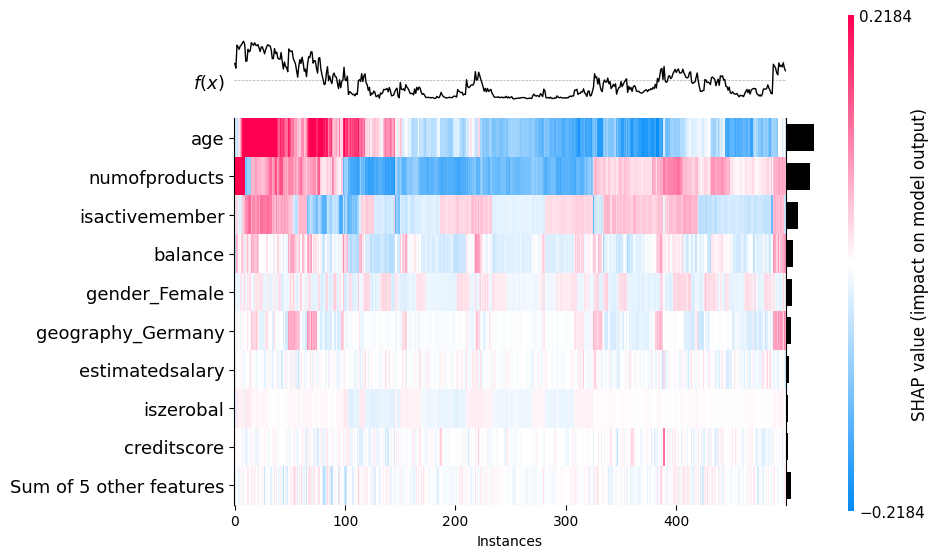

<Axes: xlabel='Instances'>

In [92]:
# heatmap plot

shap.plots.heatmap(shap_values)

### Local Plots

In [93]:
test_case = X_test[y_test == 1].sample(1)

row_shap_values = explainer(test_case)[0]

In [94]:
row_shap_values.shape

(14,)

In [95]:
df.loc[test_case.index]

,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
5962,579,Germany,Male,42.0,0,144386.32,1,1.0,1.0,22497.1,1


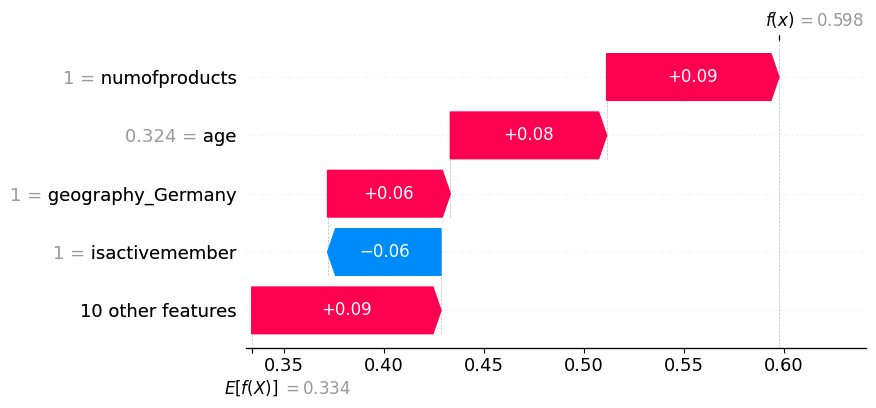

In [96]:
# waterfall plot

shap.plots.waterfall(row_shap_values, max_display=5)

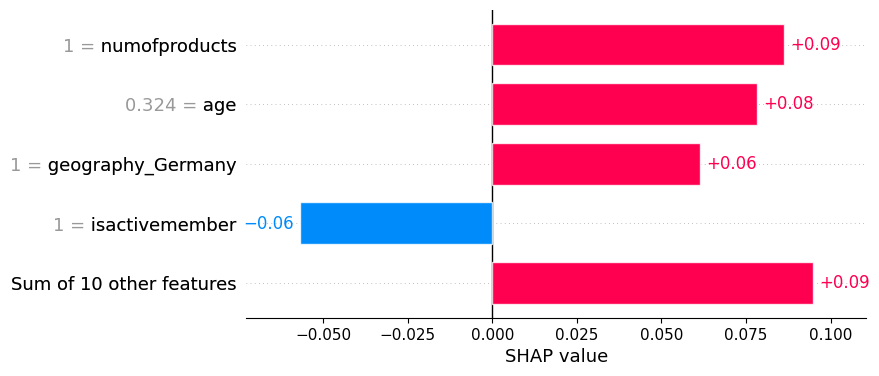

In [97]:
# bar plot--> local

shap.plots.bar(row_shap_values, max_display=5)

In [98]:
# row force plot

shap.initjs()

shap.plots.force(row_shap_values)

In [99]:
row_shap_values

.values =
array([ 0.00905326,  0.07820335,  0.04763249,  0.01676839, -0.01311966,
       -0.00563166,  0.00430629,  0.06139081,  0.00332198,  0.02410556,
        0.0862128 , -0.00053073, -0.05672587,  0.0087624 ])

.base_values =
np.float64(0.333880779639009)

.data =
array([0.458     , 0.32432432, 0.57547796, 0.11245056, 0.        ,
       1.        , 0.        , 1.        , 0.        , 0.        ,
       1.        , 1.        , 1.        , 0.        ])

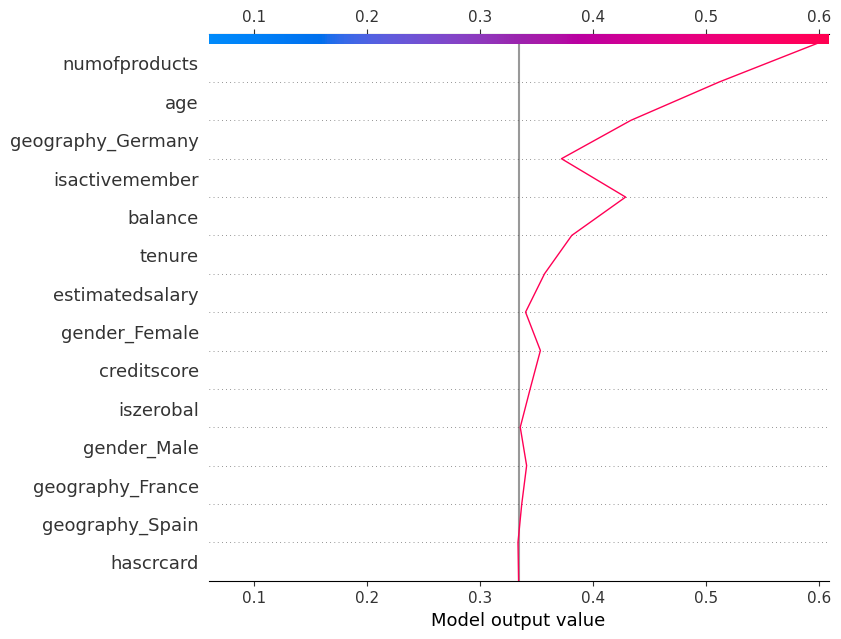

In [100]:
# decision plot

shap.plots.decision(shap_values=row_shap_values.values, base_value=row_shap_values.base_values,
                    feature_names=X_test.columns.tolist())

### Batch Data Plots

In [101]:
# sample of test data
sample_batch_data = X_test.sample(3)

# shap_values
batch_shap_values = explainer(sample_batch_data)

In [102]:
batch_shap_values.shape

(3, 14)

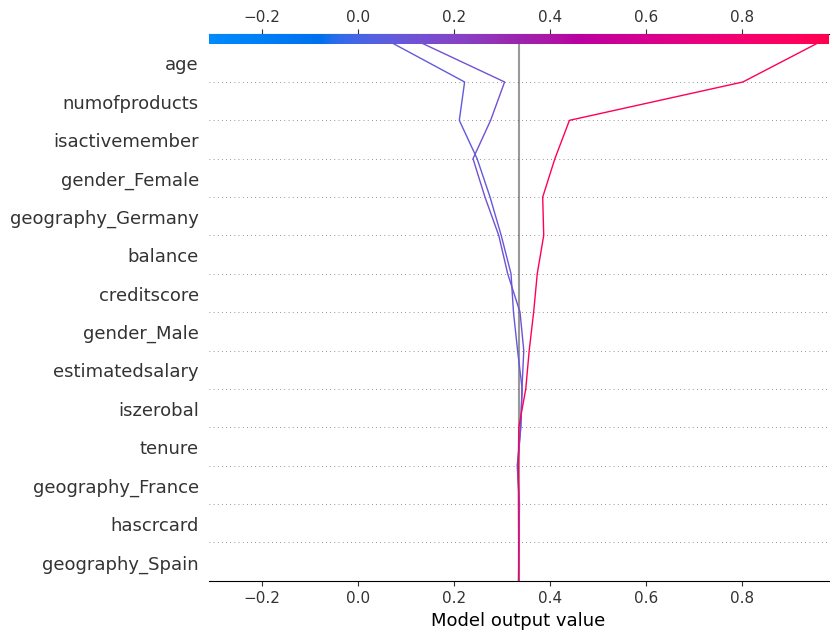

In [103]:
# decision plot

shap.plots.decision(shap_values=batch_shap_values.values, base_value=batch_shap_values.base_values[0],
                    feature_names=X_test.columns.tolist())

## LIME

In [133]:
# test case

test_case_lime = test_case.values.flatten()

In [134]:
from lime.lime_tabular import LimeTabularExplainer

In [137]:
feature_names = preprocessor.get_feature_names_out().tolist()

In [139]:
preprocessor.get_feature_names_out()

array(['creditscore', 'age', 'balance', 'estimatedsalary',
       'gender_Female', 'gender_Male', 'geography_France',
       'geography_Germany', 'geography_Spain', 'tenure', 'numofproducts',
       'hascrcard', 'isactivemember', 'iszerobal'], dtype=object)

In [140]:
# list of index numbers of categorical features in data

categorical_features = [4, 5, 6, 7, 8, 11, 12, 13]

In [141]:
# create the explainer

lime_explainer = LimeTabularExplainer(
    training_data=X_train.values,
    mode="classification",
    feature_names=feature_names,
    categorical_features=categorical_features
)

In [142]:
# create an explanation

lime_explanation = lime_explainer.explain_instance(data_row=test_case_lime,
                                                   predict_fn=model.predict_proba)

d:\shap-project\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
d:\shap-project\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [143]:
# view my explanations --> as a list

lime_explanation.as_list()

[('numofproducts <= 1.00', 0.13086845326876018),
 ('isactivemember=1', -0.11663725143465373),
 ('gender_Female=0', -0.04629349363901326),
 ('geography_Germany=1', 0.025061358181767107),
 ('iszerobal=0', 0.02250269608040988),
 ('gender_Male=1', -0.00895046796886336),
 ('balance > 0.51', 0.007186640357517678),
 ('geography_Spain=0', 0.006176150429910626),
 ('creditscore <= 0.47', 0.0053664566743933185),
 ('tenure <= 3.00', 0.005291867071789225)]

In [144]:
from IPython.core.display import HTML

In [145]:
display(HTML(lime_explanation.as_html()))